In [1]:
#%%
import os
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, ConcatDataset,random_split
import torch.nn.functional as F
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from tqdm import tqdm
import math
import torch.nn as nn
import h5py

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
device = torch.device('cuda')
dtype = torch.float32

In [4]:
#%%

#@title

#Parameters for the antenas
visible_region = 180
resolution = 1

num_antenna = 8
c0=3e8
fc= 76e9
lambda_var = c0/fc
d = lambda_var/(2*np.sin(np.pi/180*0.5*visible_region))

coordinate=np.array([0, 1, 4, 6, 13, 14, 17, 19])
NN_size_out = (visible_region/resolution)+1
NN_size_out =  np.array(NN_size_out,dtype='i')


#Create Input and Output for the NN
#aoa = matrix or vector
#A = matrix or vector
#max_gen_ang = Max_min allowed angle when generating own angles
#use_R=True Outputs the Covariance Matrix. If FALSE, outputs the snapshot
def create_i_o(SNR,aoa='random',A='default',n_angle=-1,Data_Size=-1,max_gen_ang=visible_region/2,
              return_angle=False,return_snapshot=False,use_R=False,return_Y=True,
              c0=c0,fc=fc,lambda_var=lambda_var,visible_region=visible_region,d=d,num_antenna=num_antenna,coordinate=coordinate,
              NN_size_out=NN_size_out):

    ############# INTERNAL FUNCTIONS ########################
    #
    ########################
    def get_snapshot():
        r = np.zeros((Data_Size,n_angle,num_antenna))+0*1j
        for i in range(num_antenna):
            r[:,:,i] = A*np.exp(1j*(2*np.pi*fc*coordinate[i]*d*np.sin(np.pi*aoa/180)+2*np.pi*np.random.random())/c0)
        #
        snapshot_org = np.sum(r[:,:,:],axis=1)
        #
        snapshot = awgn(snapshot_org)
        snapshot = np.array(snapshot)
        #
        if use_R==True:
            R = np.zeros((Data_Size,num_antenna,num_antenna))+0*1j
            for i in range(Data_Size):
                R[i,:,:] = np.outer(snapshot[i,:],snapshot[i,:])
            #
            if return_snapshot==False: #R_true, S_false
                return R
            else: #R_true, S_true
                return R,snapshot
        else: #R_false, S_true
            return snapshot
    #
    ########################
    def awgn(signal_snap): #add white gaussian noise
        power_snap = 10*np.log10(np.abs(signal_snap) ** 2)
        noise_dB = power_snap - SNR
        noise_energy = 10 ** (noise_dB / 10)
        noise_to_signal = np.random.normal(0, np.sqrt(noise_energy))
        Re_noise_to_signal= np.random.random((Data_Size,num_antenna))*np.abs(noise_to_signal)
        Im_noise_to_signal = np.sqrt((noise_to_signal ** 2) - (Re_noise_to_signal ** 2))
        signal_noise = Re_noise_to_signal*((-1)**np.random.randint(0,2,(Data_Size,num_antenna))) + \
                    1j*Im_noise_to_signal*((-1)**np.random.randint(0,2,(Data_Size,num_antenna)))

        noisy_signal = signal_snap + signal_noise
        return noisy_signal
    #
    #######################################################################
    #
    ########
    #Error#
    if n_angle > num_antenna-2:
        print('The number of sources is too big regarding the number of antennas!')
        return
    if n_angle < 0 and aoa == 'random':
        print('Inform either "aoa" or the "n_angle"')
        return
    if Data_Size < 0 and aoa == 'random':
        print('Inform either "Data_Size" or the "n_angle"')
        return
    ########
    #
    #Other Vars#
    if n_angle < 0:
        n_angle = aoa.shape[1]
    elif n_angle==0:
        n_angle=1
        A = np.zeros((Data_Size,n_angle))
        A[:,:] = 0.00000001
    #
    if max_gen_ang < 90 and max_gen_ang > 0 and max_gen_ang != visible_region/2:
        visible_region = 2*max_gen_ang
    #
    if aoa == 'random':
        aoa = np.random.randint(-visible_region/2,1+visible_region/2,Data_Size*n_angle)
        aoa = np.reshape(aoa,(Data_Size,n_angle))
    else:
        if Data_Size < 0:
            Data_Size = aoa.shape[0]
    #
    if A == 'default':
        A = np.ones((Data_Size,n_angle))
    #
    if Data_Size < 1:
        if aoa.ndim == 1:
            Data_Size = 1
        else:
            Data_Size = aoa.shape[0]
    Data_Size = np.array(Data_Size,dtype='i')
    #
    #Check SNR type:
    if (type(SNR) is list and len(SNR) == 2) or (type(SNR) is np.ndarray and SNR.size == 2):#If list or array and 2 elements
        SNR = np.array(SNR)
        SNR_init = SNR[0]
        SNR_end = SNR[1]
        SNR = np.random.randint(SNR_init,1+SNR_end,Data_Size) #creates the SNR with Data_Size elements
        SNR = np.transpose(np.tile(SNR, (num_antenna,1))) #Repeats the values in the row. SNR.shape is (data,num_antenna)
    #
    elif (type(SNR) is list and len(SNR) > 2) or (type(SNR) is np.ndarray and SNR.size > 2):#If more than 2 elements give error
        print('Too many arguments in for the SNR. 1 or 2 elements')
        return
    #
    #Error#
    if A.size != aoa.size:
        print('"A" size is different than "aoa" size')
        return
    ########
    #
    #OUTPUT X
    if use_R==True:
        if return_snapshot==False: #R_true, S_false
            R = get_snapshot()
        else: #R_true, S_true
            R,snapshot = get_snapshot()

        X = R
    #
    else: #R_false, S_true
        snapshot = get_snapshot()
        X = snapshot
    #
    #OUTPUT Y
    if return_Y==True:
        NN_idx = ang2NN(aoa)
    #
        Y = (1 + np.random.random((Data_Size,NN_size_out))) / 10000
        for i in range(Data_Size):
            sumY = np.sum(Y[i,:])
            Y[i,NN_idx[i,:]] = (1 - sumY) / n_angle
    #
    #RETURN
    if  return_angle==False and return_snapshot==False and return_Y==True:
        return X,Y
    elif return_angle==True and return_snapshot==False and return_Y==True:
        return X,Y,aoa
    elif return_angle==True and return_snapshot==True  and return_Y==True:
        return X,Y,aoa,snapshot
    elif return_angle==False and return_snapshot==True and return_Y==True:
        return X,Y,snapshot
    elif return_angle==False and return_snapshot==True and return_Y==False:
        return X,snapshot
    elif return_angle==True and return_snapshot==False and return_Y==False:
        return X,aoa
    elif return_angle==False and return_snapshot==False and return_Y==False:
        return X
    elif return_angle==True and return_snapshot==True and return_Y==False:
        return X,aoa,snapshot

In [5]:
def MLE2D_check(snapshot,ang_vector,
                c0=c0,fc=fc,visible_region=visible_region,coordinate=coordinate,
                lambda_var=lambda_var,d=d,resolution=resolution):

    if ang_vector == 'self':
        ang_vector = np.linspace(-90,90,181)

    X = ang_vector.size
    Y = X;
    Z = X;

    val = np.zeros((X,Y))
    val[:,:] = 1000
    snapshot = np.array(snapshot)

    for idx in range (X):
        vec1 = np.exp(1j*(2*np.pi*fc*coordinate*d*np.sin(np.pi*ang_vector[idx]/180))/c0)
        for idy in range(idx):
            vec2 = np.exp(1j*(2*np.pi*fc*coordinate*d*np.sin(np.pi*ang_vector[idy]/180))/c0)

            A = np.array([vec1,vec2])
            A = np.transpose(A)

            s = np.matmul(np.linalg.pinv(A),snapshot)
            r = np.matmul(A,s)
            df = snapshot - r
            df = np.sum(np.abs(df))
            val[idx,idy] = df


    min_val = np.min(val)
    [x,y] = np.where(val==min_val)
    ceta = np.array([ang_vector[x[0]],ang_vector[y[0]]])
    return ceta

In [6]:
def RMSE_loss(x,y):
  errors = torch.square(x-y)
  errors = torch.sqrt(torch.mean(errors,dim=1))
  errors = torch.mean(errors,dim=0)
  return errors

In [ ]:
Max_sources = 4
N_angle = 2
Data_Size = 409600

#%%
Dataset_list = []
#
SNR = [0,5,10,15,20,25,30]
Dataset_list = []
for ratio in SNR:
    x,aoa = create_i_o(ratio,n_angle=N_angle,Data_Size=Data_Size,max_gen_ang=70,
                    return_angle=True,return_Y=False)
    aoa = torch.tensor(aoa)
    x = torch.tensor(x)
    x = torch.unsqueeze(x,-2)
    hermitian_x = torch.conj(torch.transpose(x,-2,-1))
    cov_x = torch.matmul(hermitian_x,x)
    #upperCov = torch.triu(cov_x)
    #upperCov = upperCov.view(upperCov.size(0),-1)
    #get the upper triangle of the cov_x(tensor of (4096,8,8)) A and flatten it to a tensor of (4096,32)
    upper = torch.triu(cov_x)
    non_zero_elements = torch.flatten(upper[upper != 0])
    reshaped_tensor = non_zero_elements.view(Data_Size, -1)
    real = torch.real(reshaped_tensor)
    imag = torch.imag(reshaped_tensor)
    concat = torch.cat((real,imag),1)
    DataSet_WithSource = TensorDataset(concat,aoa)
    Dataset_list.append(DataSet_WithSource)

Full_dataset = ConcatDataset(Dataset_list)


In [ ]:
Train_dataset, Val_dataset = random_split(Full_dataset,[2508800,358400])

In [ ]:
batch_size = 128
Train_loader = torch.utils.data.DataLoader(
       dataset=Train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)

Val_loader = torch.utils.data.DataLoader(
       dataset=Val_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)

In [7]:
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_channels=72,channel1=1024,channel2=2048,channel3=4096,channel4=512, channel5=1024, channel6=2048, n_classes=14):
        super().__init__()
        #####################Encoder layers##############################
        self.encoder_1 = nn.Sequential(
            nn.Linear(n_channels, channel1),
            nn.BatchNorm1d(channel1),
            nn.ReLU(inplace = True),
        )

        self.encoder_2 = nn.Sequential(
            nn.Linear(channel1, channel2),
            nn.BatchNorm1d(channel2),
            nn.ReLU(inplace = True),
        )

        self.encoder_3 = nn.Sequential(
            nn.Linear(channel2, channel3),
            nn.BatchNorm1d(channel3),
            nn.ReLU(inplace = True),
        )
        self.encoder_4 = nn.Sequential(
            nn.Linear(channel3, channel3),
            nn.BatchNorm1d(channel3),
            nn.ReLU(inplace = True),
        )
        self.encoder_5 = nn.Sequential(
            nn.Linear(channel3, channel3),
            nn.BatchNorm1d(channel3),
            nn.ReLU(inplace = True),
        )
        self.encoder_6 = nn.Sequential(
            nn.Linear(channel3, channel2),
            nn.BatchNorm1d(channel2),
            nn.ReLU(inplace = True),
        )
        self.encoder_7 = nn.Sequential(
            nn.Linear(channel2, channel1),
            nn.BatchNorm1d(channel1),
            nn.ReLU(inplace = True),
        )
        self.regression4 = nn.Sequential(
            nn.Linear(channel1, 141),
            nn.Sigmoid(),
        )
    def forward(self,x):

        x = self.encoder_1(x)

        x = self.encoder_2(x)

        x = self.encoder_3(x)

        x = self.encoder_4(x)

        x = self.encoder_5(x)

        x = self.encoder_6(x)

        x = self.encoder_7(x)

        reg4 = self.regression4(x)

        return reg4

In [ ]:
Model = MLP()
weight_decay = 1e-4
optimizer = optim.Adam(Model.parameters(), lr=0.001)
Model = Model.to(device=device)
#model = model.to(device=device)  # move the model parameters to CPU/GPU
epochs = 30

In [ ]:
# Model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/FC_regression_pdf_2.pth"))

<All keys matched successfully>

In [ ]:

def create_label(y):
  a = torch.zeros(128,141)
  a = a.to(device=device)
  y = (y+70).long()
  a.scatter_(1,y,1)
  return a

In [ ]:
# tst = torch.rand(128,72)
# out = Model(tst)
# print(out.shape)
for e in range(epochs):
    for t, (x, y) in enumerate(tqdm(Train_loader)):
        Model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=dtype)
        optimizer.zero_grad()
        aoa3 = Model(x)
        # _,prediction = torch.topk(aoa3,k=3,dim=1)
        # prediction.requires_grad(True)
        label = create_label(y)
        loss_reg = F.mse_loss(aoa3, label)
        loss_reg.backward()

        optimizer.step()

    if e%2 == 0:
        print('Epoch %d, Classification loss = %.4f' % (e, loss_reg.item()))

    with torch.no_grad():
        Model.eval()
        for idx,(x,y) in enumerate(tqdm(Val_loader)):
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=dtype)
                reg4 = Model(x)
                _,estimation = torch.topk(reg4,k=2,dim=1)
                directions = estimation-70
                labell = create_label(y)
                loss_reg_val = F.mse_loss(reg4, labell)
                loss = loss_reg_val
                direction,_ = torch.sort(directions)
                y,_ = torch.sort(y)
                loss_RMSE = F.mse_loss(direction,y)
                loss_RMSE = torch.sqrt(loss_RMSE)
        if e%2 == 0:
            print('Epoch %d, validation loss = %.4f' % (e, loss))
            print(f'Epoch {e}, Truth ={y[0,:]}')
            print(f'Epoch {e}, sources ={direction[0,:]}')
            print(f'Epoch {e}, RMSE ={loss_RMSE}')


100%|██████████| 19600/19600 [02:36<00:00, 125.13it/s]


Epoch 0, Classification loss = 0.0035


100%|██████████| 2800/2800 [00:09<00:00, 303.80it/s]


Epoch 0, validation loss = 0.0036
Epoch 0, Truth =tensor([-34.,  -8.], device='cuda:0')
Epoch 0, sources =tensor([-34,  -8], device='cuda:0')
Epoch 0, RMSE =16.769811630249023


100%|██████████| 19600/19600 [02:36<00:00, 125.61it/s]


Epoch 2, Classification loss = 0.0038


100%|██████████| 2800/2800 [00:09<00:00, 305.80it/s]


Epoch 2, validation loss = 0.0035
Epoch 2, Truth =tensor([-55., -25.], device='cuda:0')
Epoch 2, sources =tensor([-55, -25], device='cuda:0')
Epoch 2, RMSE =19.41689109802246


100%|██████████| 19600/19600 [02:36<00:00, 125.62it/s]


Epoch 4, Classification loss = 0.0037


100%|██████████| 2800/2800 [00:09<00:00, 305.13it/s]


Epoch 4, validation loss = 0.0035
Epoch 4, Truth =tensor([21., 37.], device='cuda:0')
Epoch 4, sources =tensor([21, 38], device='cuda:0')
Epoch 4, RMSE =16.952484130859375


100%|██████████| 19600/19600 [02:36<00:00, 125.62it/s]


Epoch 6, Classification loss = 0.0042


100%|██████████| 2800/2800 [00:09<00:00, 306.21it/s]


Epoch 6, validation loss = 0.0046
Epoch 6, Truth =tensor([-58.,  28.], device='cuda:0')
Epoch 6, sources =tensor([-58,  28], device='cuda:0')
Epoch 6, RMSE =19.28152847290039


100%|██████████| 19600/19600 [02:35<00:00, 125.71it/s]


Epoch 8, Classification loss = 0.0031


100%|██████████| 2800/2800 [00:09<00:00, 305.12it/s]


Epoch 8, validation loss = 0.0031
Epoch 8, Truth =tensor([-67., -10.], device='cuda:0')
Epoch 8, sources =tensor([-67, -10], device='cuda:0')
Epoch 8, RMSE =16.79901885986328


100%|██████████| 19600/19600 [02:35<00:00, 125.71it/s]


Epoch 10, Classification loss = 0.0033


100%|██████████| 2800/2800 [00:09<00:00, 302.88it/s]


Epoch 10, validation loss = 0.0028
Epoch 10, Truth =tensor([-67., -21.], device='cuda:0')
Epoch 10, sources =tensor([-67, -21], device='cuda:0')
Epoch 10, RMSE =16.98885154724121


100%|██████████| 19600/19600 [02:36<00:00, 125.24it/s]


Epoch 12, Classification loss = 0.0037


100%|██████████| 2800/2800 [00:09<00:00, 305.43it/s]


Epoch 12, validation loss = 0.0033
Epoch 12, Truth =tensor([ 4., 48.], device='cuda:0')
Epoch 12, sources =tensor([ 4, 48], device='cuda:0')
Epoch 12, RMSE =16.483182907104492


100%|██████████| 19600/19600 [02:36<00:00, 125.62it/s]


Epoch 14, Classification loss = 0.0031


100%|██████████| 2800/2800 [00:09<00:00, 305.24it/s]


Epoch 14, validation loss = 0.0031
Epoch 14, Truth =tensor([-15.,  43.], device='cuda:0')
Epoch 14, sources =tensor([-15,  43], device='cuda:0')
Epoch 14, RMSE =12.693347930908203


100%|██████████| 19600/19600 [02:36<00:00, 125.31it/s]


Epoch 16, Classification loss = 0.0033


100%|██████████| 2800/2800 [00:09<00:00, 303.90it/s]


Epoch 16, validation loss = 0.0035
Epoch 16, Truth =tensor([-48.,  -6.], device='cuda:0')
Epoch 16, sources =tensor([-46,  -5], device='cuda:0')
Epoch 16, RMSE =20.35399627685547


100%|██████████| 19600/19600 [02:35<00:00, 125.69it/s]


Epoch 18, Classification loss = 0.0028


100%|██████████| 2800/2800 [00:09<00:00, 305.66it/s]


Epoch 18, validation loss = 0.0038
Epoch 18, Truth =tensor([-70.,  62.], device='cuda:0')
Epoch 18, sources =tensor([-70,  62], device='cuda:0')
Epoch 18, RMSE =11.234189987182617


100%|██████████| 19600/19600 [02:36<00:00, 125.51it/s]


Epoch 20, Classification loss = 0.0031


100%|██████████| 2800/2800 [00:09<00:00, 305.75it/s]


Epoch 20, validation loss = 0.0033
Epoch 20, Truth =tensor([-62., -20.], device='cuda:0')
Epoch 20, sources =tensor([-62, -20], device='cuda:0')
Epoch 20, RMSE =16.920656204223633


100%|██████████| 19600/19600 [02:35<00:00, 125.73it/s]


Epoch 22, Classification loss = 0.0032


100%|██████████| 2800/2800 [00:09<00:00, 305.20it/s]


Epoch 22, validation loss = 0.0027
Epoch 22, Truth =tensor([-27.,  31.], device='cuda:0')
Epoch 22, sources =tensor([-27,  31], device='cuda:0')
Epoch 22, RMSE =10.990052223205566


100%|██████████| 19600/19600 [02:36<00:00, 125.63it/s]


Epoch 24, Classification loss = 0.0034


100%|██████████| 2800/2800 [00:09<00:00, 305.61it/s]


Epoch 24, validation loss = 0.0030
Epoch 24, Truth =tensor([-37.,  69.], device='cuda:0')
Epoch 24, sources =tensor([-37,  69], device='cuda:0')
Epoch 24, RMSE =11.516122817993164


100%|██████████| 19600/19600 [02:36<00:00, 125.55it/s]


Epoch 26, Classification loss = 0.0029


100%|██████████| 2800/2800 [00:09<00:00, 304.64it/s]


Epoch 26, validation loss = 0.0034
Epoch 26, Truth =tensor([-50., -27.], device='cuda:0')
Epoch 26, sources =tensor([-50, -27], device='cuda:0')
Epoch 26, RMSE =14.325730323791504


100%|██████████| 19600/19600 [02:35<00:00, 125.67it/s]


Epoch 28, Classification loss = 0.0023


100%|██████████| 2800/2800 [00:09<00:00, 305.64it/s]


Epoch 28, validation loss = 0.0029
Epoch 28, Truth =tensor([-22.,  30.], device='cuda:0')
Epoch 28, sources =tensor([-22,  30], device='cuda:0')
Epoch 28, RMSE =15.138423919677734


100%|██████████| 2800/2800 [00:09<00:00, 305.98it/s]


In [ ]:
torch.save(Model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/FC_regression_pdf_22.pth')

In [9]:
Max_sources = 4
N_angle = 2
Data_Size = 4096
Model = MLP()
Model = Model.to(device='cpu')
Model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/FC_regression_pdf_2.pth"))
Model.eval()
#
SNR = [0,5,10,15,20,25,30]
RMSE_list = []
for ratio in SNR:
    x,aoa = create_i_o(ratio,n_angle=2,Data_Size=Data_Size,max_gen_ang=70,
                    return_angle=True,return_Y=False)
    aoa = torch.tensor(aoa)
    snap = x
    x = torch.tensor(x)
    x = torch.unsqueeze(x,-2)
    hermitian_x = torch.conj(torch.transpose(x,-2,-1))
    cov_x = torch.matmul(hermitian_x,x)
    #upperCov = torch.triu(cov_x)
    #upperCov = upperCov.view(upperCov.size(0),-1)
    #get the upper triangle of the cov_x(tensor of (4096,8,8)) A and flatten it to a tensor of (4096,32)
    upper = torch.triu(cov_x)
    non_zero_elements = torch.flatten(upper[upper != 0])
    reshaped_tensor = non_zero_elements.view(Data_Size, -1)
    real = torch.real(reshaped_tensor)
    imag = torch.imag(reshaped_tensor)
    concat = torch.cat((real,imag),1)
    concat = concat.to(device='cpu',dtype=dtype)
    #-------------------------------------------
    reg4 = Model(concat)
    _,estimation = torch.topk(reg4,k=6,dim=1)
    directions = estimation-70
    directions,_ = torch.sort(directions)
    predictions = np.zeros(aoa.shape)
    for i in range(Data_Size):
      predictions[i,:] = MLE2D_check(snap[i,:],ang_vector = np.array(directions[i,:]))
    predictions = torch.tensor(predictions)
    predictions,_ = torch.sort(predictions)
    aoa,_ = torch.sort(aoa)
    RMSE = RMSE_loss(predictions,aoa)
    RMSE_list.append(RMSE.item())


<ipython-input-5-3aaeba0e6291>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ang_vector == 'self':


In [17]:
Model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/FC_regression_pdf_2.pth"))

<All keys matched successfully>

In [20]:
SNR = 0     #start
SNR_inc = 5  #increase
SNR_end = 30 #end
n_angle = 2
max_region = 70
K = 100  #Number of group of angles per SNR
L = 5  #Monte Carlo Tests

aoa = np.random.rand(K*n_angle)*(max_region*2)-(max_region) #non-integer
aoa = np.reshape(aoa,(K,n_angle))

rmse_size = np.array(1+(SNR_end-SNR)/SNR_inc,dtype='i')
rmse_vec = np.zeros((rmse_size))

m=0
while (SNR <= SNR_end):

    vec_ang_rmse = np.zeros((L))
    ang = np.zeros((n_angle))
    for i in range(L):

        X,snap = create_i_o(SNR=SNR,aoa=aoa,return_Y=False,use_R=True,return_snapshot=True)
        X = torch.tensor(X)
        upper = torch.triu(X)
        non_zero_elements = torch.flatten(upper[upper != 0])
        reshaped_tensor = non_zero_elements.view(100, -1)
        real = torch.real(reshaped_tensor)
        imag = torch.imag(reshaped_tensor)
        concat = torch.cat((real,imag),1)
        concat = concat.to(dtype = dtype)
        diff = [] #diff vector
        for j in range(K):

            #Calculate real angles
            ang = aoa[j,:]
            input = concat[j,:]
            input = torch.unsqueeze(input,0)
            #Predict angles
            reg4 = Model(input)
            _,estimation = torch.topk(reg4,k=72,dim=1)
            directions = estimation-70
            directions,_ = torch.sort(directions)
            directions = torch.squeeze(directions)
            predictions = MLE2D_check(snap[j,:],ang_vector = np.array(directions))

            #Takes the difference of predicted and real angles
            for k in range(n_angle):
                dif = ang - predictions[k]
                dif_a = np.abs(dif)
                dif_s = np.sort(dif_a)
                temp = dif_s[0]
                diff.append(temp) #Add the minimum diff

        #Calculate RMSE
        diff = np.array(diff)
        diff2 = diff ** 2
        mdiff = np.mean(diff2)
        ang_rmse = np.sqrt(mdiff)
        vec_ang_rmse[i] = ang_rmse


    #Calculate Monte-Carlo
    vec_ang_rmse = np.array(vec_ang_rmse)
    rmse_vec[m] = np.mean(vec_ang_rmse)
    m += 1
    SNR += SNR_inc
print(rmse_vec) #print the result

<ipython-input-4-2126ef5ddaa3>:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if n_angle < 0 and aoa == 'random':
<ipython-input-4-2126ef5ddaa3>:79: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Data_Size < 0 and aoa == 'random':
<ipython-input-4-2126ef5ddaa3>:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if aoa == 'random':
<ipython-input-5-3aaeba0e6291>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ang_vector == 'self':


[27.38145998 19.16259904 12.60598237  9.36324547  9.32055755  9.3301412
  6.29179624]


In [22]:
DOA2_MLE = np.array([29.997371,     20.2326,      7.2418,      2.7213,      0.4642,      0.3828,      0.3530])
rmse_list = np.array([29.97142453, 20.10335803, 14.33223601,  7.68013178,  6.82495802,  6.20365921,
  6.49239249])

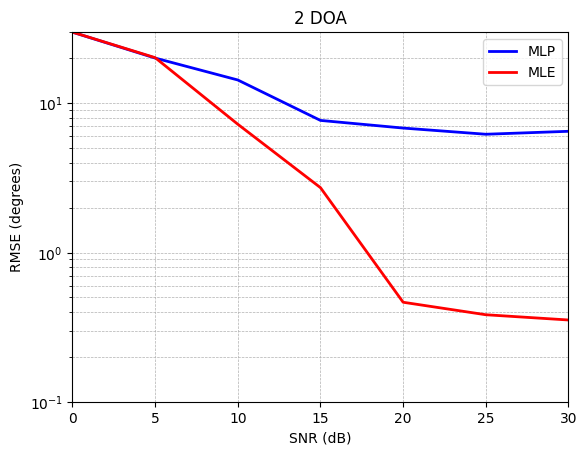

In [25]:
import matplotlib.pyplot as plt
linewidth = 2
color1 = 'blue'
color2 = 'red'
color3 = 'green'
SNR = [0,5,10,15,20,25,30]
plt.figure()
plt.title('2 DOA')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE (degrees)')
plt.semilogy(SNR, rmse_list, linewidth=linewidth, color=color1, label='MLP')
plt.semilogy(SNR, DOA2_MLE, linewidth=linewidth, color=color2, label='MLE')     #Plot 2       #Plot 1    #Plot 3
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Adjust grid spacing
plt.ylim([0.1, 30])
plt.xlim([0, 30])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MLP_pdf_2_monte.png',dpi=300,)
plt.show()

In [ ]:
print(predictions[520,:])

tensor([26., 46., 60.], dtype=torch.float64)


In [ ]:
tst,_ = torch.sort(directions[0,:])
tst = np.array(tst)
print(tst)


[ 7 21 22 42 43 44]


In [19]:
print(rmse_vec)

[29.97142453 20.10335803 14.33223601  7.68013178  6.82495802  6.20365921
  6.49239249]


In [ ]:
print(aoa[520,:])

tensor([26, 46, 60])


In [11]:
print(RMSE_list)

[18.35303521878238, 4.452132531742037, 0.7802267898224943, 0.4041789896974033, 0.18397546708470636, 0.17012646591015146, 0.1472635550790156]


In [ ]:
errors = torch.square(predictions-aoa)
print(errors.shape)
errors = torch.sqrt(torch.mean(errors,dim=1))
print(errors.shape)
errors = torch.mean(errors,dim=0)
print(errors.shape)
print(errors)

torch.Size([4096, 3])
torch.Size([4096])
torch.Size([])
tensor(0.3653, dtype=torch.float64)
